In [10]:
import os
import numpy as np
import random
from transforms3d.euler import euler2mat, mat2euler
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib notebook')
from mpl_toolkits.mplot3d import Axes3D
import skimage.transform
#import SimpleITK as sitk
import nrrd

In [11]:
def synthetic_generation(num_needles, degree, std=None, mean=None):
    DATAPATH = "/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00"
    CASEPATH = [DATAPATH + '/' + s for s in os.listdir(DATAPATH) if s != '.DS_Store']

    needlepaths = []
    casepaths = []
    for case in CASEPATH:
        needlepath = [case + '/' + s for s in os.listdir(case) if 'needle' in s]
        casepath = [case + '/' + s for s in os.listdir(case) if 'case' in s]
        needlepaths = needlepaths + needlepath
        casepaths = casepaths + casepath
    print('Number of Needles:',len(needlepaths))
    print("Number of Cases:",len(casepaths))
    
    #load needles
    needles = []
    random.shuffle(needlepaths)
    for needlepath in needlepaths:
        needleimg = nrrd.read(needlepath)
        needlearray = needleimg[0]
        needlearray[needlearray != 0] = 1
        needles.append(needlearray)
        
    #load cases
    cases = []
    for casepath in casepaths:
        caseimg = nrrd.read(casepath)
        casearray = caseimg[0]
        cases.append(casearray)
    
    #generate synthetic labelmap
    labelmap_syn = np.zeros((255,319,319),int)    
    for i,needle in enumerate(needles[0:num_needles]):
        print(needlepaths[i])
        xs, ys, zs = np.where(needle == 1)
        I = np.asarray([[x, y, z] for x, y, z in zip(xs,ys,zs)])
        I = np.transpose(I)
        x_angle = (random.random()-0.5)*2 *degree*np.pi/180
        y_angle = (random.random()-0.5)*2 *degree*np.pi/180
        z_angle = (random.random()-0.5)*2 *degree*np.pi/180
        R = euler2mat(x_angle, y_angle, z_angle, 'sxyz')
        try:
            M = np.transpose(np.dot(R,I)).astype(int)
        except ValueError:
            print("Empty Needle",needlepaths[i])
        needle_rot = np.zeros((255,319,319),int)
        for x,y,z in M:
            try:
                needle_rot[x][y][z] = 1
            except IndexError:
                #print("Exceed Boundary")
                continue
        labelmap_syn = labelmap_syn + needle_rot
    
    unique, count = np.unique(labelmap_syn, return_counts=True)
    print(unique, count)
    
    #generate synthetic case
    #cases_flattened = [sublist4 for sublist1 in cases for sublist2 in sublist1 for sublist3 in sublist2 for sublist4 in sublist3]  
    if std == None:
        std = np.std(cases[0])
    if mean == None:
        mean = np.mean(cases[0])
    case_syn = np.random.normal(std, mean, (255,319,319))
    case_syn[labelmap_syn != 0] = 0
    
    return labelmap_syn,case_syn

In [12]:
labelmap, case = synthetic_generation(10, 10)

Number of Needles: 637
Number of Cases: 48
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/026/needle-11.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/031/needle-7.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/025/needle-6.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/072/needle-10.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/029/needle-7.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/034/needle-0.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/059/needle-27.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/026/needle-10.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/030/needle-3.nrrd
/home/ubuntu/preprocessed_data/LabelMaps_1.00-1.00-1.00/044/needle-13.nrrd
[0 1] [25941271     7784]


<IPython.core.display.Javascript object>


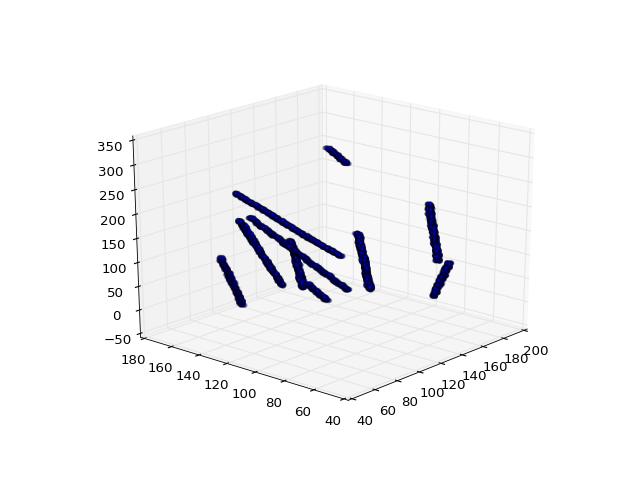

In [13]:
#xs, ys, zs = np.where(labelmap != 0)
#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.scatter(xs, ys, zs, marker='o', alpha=0.3, s=10)